**The Last 15 Years Earth Quake Analysis** 

*1-  Scraping for getting data for analysis from "https://earthquake.usgs.gov/earthquakes/search/#%7B%22currentfeatureid%22%3Anull%2C%22mapposition%22%3A%5B%5B74.13408%2C-225.4834%5D%2C%5B77.57996%2C-205.7959%5D%5D%2C%22autoUpdate%22%3A%5B%22autoUpdate%22%5D%2C%22feed%22%3A%22undefined_undefined%22%2C%22listFormat%22%3A%22default%22%2C%22restrictListToMap%22%3A%5B%5D%2C%22sort%22%3A%22newest%22%2C%22basemap%22%3A%22grayscale%22%2C%22overlays%22%3A%5B%22plates%22%5D%2C%22distanceUnit%22%3A%22km%22%2C%22timezone%22%3A%22local%22%2C%22viewModes%22%3A%5B%22list%22%2C%22settings%22%2C%22map%22%5D%2C%22event%22%3Anull%2C%22search%22%3Anull%7D "*

In [1]:
import os
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
#checking if file already exist to skip overloading each time i open the notebook
filename = "earthquakes_2010_tillnoww.csv"

if os.path.exists(filename):
    print("📂 File found. Loading earthquake data from CSV...")
    quakes = pd.read_csv(filename, parse_dates=["time"])
else:
    print("🌐 File not found. Downloading data from USGS API...")
    all_quakes = []

    for year in range(2010, datetime.now().year + 1):
        for month in range(1, 13):
            # Skip future months of the current year
            if year == datetime.now().year and month > datetime.now().month:
                break

            start = datetime(year, month, 1)
            end = (start + timedelta(days=32)).replace(day=1) - timedelta(days=1)
            start_str = start.strftime("%Y-%m-%d")
            end_str = end.strftime("%Y-%m-%d")

            print(f"📦 Fetching earthquakes for {start_str} to {end_str}...")

            url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
            params = {
                "format": "geojson",
                "starttime": start_str,
                "endtime": end_str,
                "minmagnitude": 2.5,
                "orderby": "time-asc",
                "limit": 20000  # Still keep this for each monthly chunk
            }

            response = requests.get(url, params=params)

            if response.status_code == 200:
                data = response.json()
                features = data.get("features", [])

                if not features:
                    continue

                month_quakes = pd.DataFrame([{
                    "time": f["properties"]["time"],
                    "place": f["properties"]["place"],
                    "mag": f["properties"]["mag"],
                    "depth": f["geometry"]["coordinates"][2],
                    "longitude": f["geometry"]["coordinates"][0],
                    "latitude": f["geometry"]["coordinates"][1]
                } for f in features])

                all_quakes.append(month_quakes)
            else:
                print(f"⚠️ Failed to fetch data for {start_str}. Status code: {response.status_code}")

    quakes = pd.concat(all_quakes, ignore_index=True)
    quakes["time"] = pd.to_datetime(quakes["time"], unit='ms')
    quakes.to_csv(filename, index=False)
    print("✅ All earthquake data saved successfully.")


📂 File found. Loading earthquake data from CSV...


In [2]:
quakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399854 entries, 0 to 399853
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   time       399854 non-null  datetime64[ns]
 1   place      399854 non-null  object        
 2   mag        399854 non-null  float64       
 3   depth      399854 non-null  float64       
 4   longitude  399854 non-null  float64       
 5   latitude   399854 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 18.3+ MB


**2- Cleaning data**

* Extract month name and year and store them into new columns

In [3]:
# Convert to datetime and extract month name and year and store them into new columns

quakes['month'] = pd.to_datetime(quakes['time']).dt.strftime('%B')
quakes['year'] = pd.to_datetime(quakes['time']).dt.strftime('%Y')
# previewing quakes dataframe to see new columns [month],[year]
quakes.head()

,time,place,mag,depth,longitude,latitude,month,year
0,2010-01-01 02:08:21.900,"73 km SSW of Lijiang, China",5.00,10.000,99.866000,26.290000,January,2010
1,2010-01-01 02:22:23.820,"201 km NW of Saga, China",5.20,10.000,83.791000,30.646000,January,2010
2,2010-01-01 02:33:42.820,"11km N of Delta, B.C., MX",3.24,5.995,-115.202833,32.453833,January,2010
3,2010-01-01 02:34:56.050,"117 km NW of Türkmenba?y, Turkmenistan",5.00,46.100,51.925000,40.726000,January,2010
4,2010-01-01 02:55:04.370,"26km NNE of Trona, CA",2.79,0.658,-117.298333,35.985167,January,2010


* Getting Country names from Latitude and Longitude columns by spatial Join using geopandas

In [4]:
# installing required libraries for spatial Join using geopandas to get country name from [longitude] and [latitude] columns
!pip install geopy
!pip install geopandas

In [5]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import os

shapefile_path = "C:/Desktop2/techmind data/practice projects/path_country/ne_10m_admin_0_countries.shp"

if not os.path.exists("quakes_with_country2.csv"):
    # Load and buffer shapefile only when needed
    world = gpd.read_file(shapefile_path)
    world_projected = world.to_crs(epsg=3857)
    world_projected['geometry'] = world_projected.buffer(5000)
    world_buffered = world_projected.to_crs(epsg=4326)

    # Load raw earthquake data
    quakes = pd.read_csv("quakes_raw.csv")  # assuming raw data filename
    geometry = [Point(xy) for xy in zip(quakes['longitude'], quakes['latitude'])]
    quakes_gdf = gpd.GeoDataFrame(quakes, geometry=geometry, crs='EPSG:4326')

    # Spatial join
    quakes_with_country = gpd.sjoin(
        quakes_gdf,
        world_buffered[['ADMIN', 'geometry']],
        how='left',
        predicate='intersects'
    )

    quakes['country'] = quakes_with_country['ADMIN']
    quakes.to_csv("quakes_with_country2.csv", index=False)
else:
    quakes = pd.read_csv("quakes_with_country2.csv")


In [6]:
# Saving result of spatial join
quakes.to_csv("quakes_with_country2.csv", index=False)

In [7]:
# previewing quakes dataframe to check for [country] column  
quakes.head()

,time,place,mag,depth,longitude,latitude,month,year,country
0,2010-01-01 02:08:21.900,"73 km SSW of Lijiang, China",5.00,10.000,99.866000,26.290000,January,2010,China
1,2010-01-01 02:22:23.820,"201 km NW of Saga, China",5.20,10.000,83.791000,30.646000,January,2010,China
2,2010-01-01 02:33:42.820,"11km N of Delta, B.C., MX",3.24,5.995,-115.202833,32.453833,January,2010,Mexico
3,2010-01-01 02:34:56.050,"117 km NW of Türkmenba?y, Turkmenistan",5.00,46.100,51.925000,40.726000,January,2010,NaN
4,2010-01-01 02:55:04.370,"26km NNE of Trona, CA",2.79,0.658,-117.298333,35.985167,January,2010,United States of America


In [8]:
#checking for null values in new column [country]
quakes['country'].isnull().sum()

257528

In [9]:
# fill null values in country column with  Extract country name from place column if comma exists; else use whole string
quakes.loc[quakes['country'].isna(), 'country'] = quakes.loc[quakes['country'].isna(), 'place'].apply(
    lambda x: x.split(',')[-1].strip() if ',' in x else x.strip()
)

In [10]:
#checking for null values in new column [country]
quakes['country'].isnull().sum()

0

In [11]:
quakes.head(100)

,time,place,mag,depth,longitude,latitude,month,year,country
0,2010-01-01 02:08:21.900,"73 km SSW of Lijiang, China",5.00,10.000,99.866000,26.290000,January,2010,China
1,2010-01-01 02:22:23.820,"201 km NW of Saga, China",5.20,10.000,83.791000,30.646000,January,2010,China
2,2010-01-01 02:33:42.820,"11km N of Delta, B.C., MX",3.24,5.995,-115.202833,32.453833,January,2010,Mexico
3,2010-01-01 02:34:56.050,"117 km NW of Türkmenba?y, Turkmenistan",5.00,46.100,51.925000,40.726000,January,2010,Turkmenistan
4,2010-01-01 02:55:04.370,"26km NNE of Trona, CA",2.79,0.658,-117.298333,35.985167,January,2010,United States of America
...,...,...,...,...,...,...,...,...,...
95,2010-01-03 21:56:49.190,"96 km SE of Gizo, Solomon Islands",4.60,32.500,157.434000,-8.745000,January,2010,Solomon Islands
96,2010-01-03 22:02:30.970,"104 km SE of Gizo, Solomon Islands",4.50,35.000,157.493000,-8.785000,January,2010,Solomon Islands
97,2010-01-03 22:03:41.240,"84 km SE of Gizo, Solomon Islands",4.40,35.000,157.365000,-8.667000,January,2010,Solomon Islands
98,2010-01-03 22:05:42.330,"113 km SE of Gizo, Solomon Islands",4.60,35.000,157.539000,-8.862000,January,2010,Solomon Islands


* Standarizing country column name

In [12]:
import pandas as pd

# Step 1: Primary country mapping
mapping_df = pd.read_excel("Country_Standardization6_Map.xlsx")
replacement_dict = dict(zip(mapping_df["Original Entry"], mapping_df["Resolved Name"]))
quakes["standardized_country"] = quakes["country"].map(replacement_dict)

# Step 2: Secondary region-country mapping
region_df = pd.read_csv("region_country_mapping2.csv")
region_dict = dict(zip(region_df["Region"], region_df["Country"]))

# Step 3: Function to further map region names to country names
def resolve_region_to_country(value):
    if pd.isna(value):
        return value
    return region_dict.get(value, value)

quakes["standardized_country"] = quakes["standardized_country"].apply(resolve_region_to_country)

In [13]:
quakes.head()

,time,place,mag,depth,longitude,latitude,month,year,country,standardized_country
0,2010-01-01 02:08:21.900,"73 km SSW of Lijiang, China",5.00,10.000,99.866000,26.290000,January,2010,China,China
1,2010-01-01 02:22:23.820,"201 km NW of Saga, China",5.20,10.000,83.791000,30.646000,January,2010,China,China
2,2010-01-01 02:33:42.820,"11km N of Delta, B.C., MX",3.24,5.995,-115.202833,32.453833,January,2010,Mexico,Mexico
3,2010-01-01 02:34:56.050,"117 km NW of Türkmenba?y, Turkmenistan",5.00,46.100,51.925000,40.726000,January,2010,Turkmenistan,Turkmenistan
4,2010-01-01 02:55:04.370,"26km NNE of Trona, CA",2.79,0.658,-117.298333,35.985167,January,2010,United States of America,United States of America


* Summary of Differences between country column and new column of standarized countries



In [14]:
differences = quakes[quakes['country'] != quakes['standardized_country']]
print(f"🔍 Found {len(differences)} mismatches")


🔍 Found 87021 mismatches


In [15]:
# Previewing mismstch values side by side
mismatches = quakes[quakes['country'] != quakes['standardized_country']]
mismatches[['country', 'standardized_country']].head(20)


,country,standardized_country
11,Kuril Islands,Russia
12,Azores Islands region,Portugal
15,Mid-Indian Ridge,International Waters
16,Alaska,United States of America
19,Alaska,United States of America
23,Carlsberg Ridge,India
25,Carlsberg Ridge,India
26,Banda Sea,Indonesia
29,Alaska,United States of America
31,Mid-Indian Ridge,International Waters


In [16]:
quakes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399854 entries, 0 to 399853
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   time                  399854 non-null  object 
 1   place                 399854 non-null  object 
 2   mag                   399854 non-null  float64
 3   depth                 399854 non-null  float64
 4   longitude             399854 non-null  float64
 5   latitude              399854 non-null  float64
 6   month                 399854 non-null  object 
 7   year                  399854 non-null  int64  
 8   country               399854 non-null  object 
 9   standardized_country  399826 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 30.5+ MB


In [17]:
quakes.describe()

,mag,depth,longitude,latitude,year
count,399854.000000,399854.000000,399854.000000,399854.000000,399854.000000
mean,3.814373,56.680252,-31.980692,18.913066,2017.532119
std,0.885322,104.841740,125.515669,30.506742,4.334358
min,0.700000,-3.740000,-179.999700,-84.422000,2010.000000
25%,2.900000,10.000000,-150.130275,-5.253700,2014.000000
50%,4.100000,17.154500,-69.362000,19.412667,2018.000000
75%,4.500000,52.326250,121.484675,42.650550,2021.000000
max,9.100000,697.360000,179.999900,87.386000,2025.000000


* Getting more data about earth quakes by downloading tsv file from https://www.ngdc.noaa.gov/hazel/view/hazards/earthquake/search


In [18]:
# open a downloaded file and previewing it's data
file_path = "C:/Users/suzan/OneDrive/2010-2025Earthquakesinfo.xlsx"
data = pd.read_excel(file_path)
data.head()

,Search Parameters,Year,Mo,Dy,Hr,Mn,Sec,Tsu,Vol,Location Name,...,Total Missing,Total Missing Description,Total Injuries,Total Injuries Description,Total Damage ($Mil),Total Damage Description,Total Houses Destroyed,Total Houses Destroyed Description,Total Houses Damaged,Total Houses Damaged Description
0,"[""2010 <= Year >= 2025""]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2010.0,1.0,2.0,2.0,15.0,12.0,NaN,NaN,TAJIKISTAN,...,NaN,NaN,NaN,NaN,1.5,2.0,98.0,2.0,1000.0,3.0
2,NaN,2010.0,1.0,3.0,21.0,48.0,5.3,4522.0,NaN,SOLOMON ISLANDS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,2010.0,1.0,3.0,22.0,36.0,27.9,4523.0,NaN,SOLOMON ISLANDS,...,NaN,NaN,NaN,NaN,NaN,1.0,16.0,1.0,60.0,2.0
4,NaN,2010.0,1.0,5.0,12.0,15.0,32.2,4542.0,NaN,SOLOMON ISLANDS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Search Parameters                   1 non-null      object 
 1   Year                                802 non-null    float64
 2   Mo                                  802 non-null    float64
 3   Dy                                  802 non-null    float64
 4   Hr                                  801 non-null    float64
 5   Mn                                  801 non-null    float64
 6   Sec                                 798 non-null    float64
 7   Tsu                                 216 non-null    float64
 8   Vol                                 9 non-null      float64
 9   Location Name                       802 non-null    object 
 10  Latitude                            802 non-null    float64
 11  Longitude                           802 non-n

**Merge between 2 Dataframe to get more information about earthquakes**

In [20]:
# preparing match columns of the 2 dataframes for merging 
quakes['lat'] = quakes['latitude'].round(2)
quakes['lon'] = quakes['longitude'].round(2)
data['lat'] = data['Latitude'].round(2)
data['lon'] = data['Longitude'].round(2)
quakes['time'] = pd.to_datetime(quakes['time'], errors='coerce')
quakes['year'] = quakes['time'].dt.year.astype('Int64')  # 'Int64' handles NaT gracefully
quakes['year'] = quakes['time'].dt.year.astype('Int64')
data['year'] = data['Year'].astype('Int64')


# Merging quakes dataframe with dataframe left join 
merged_df = pd.merge(
    quakes, data,
    on=['lat', 'lon', 'year'],  
    how='left',
    suffixes=('', '_extra')
)


In [21]:
total = len(merged_df)
matched = merged_df['latitude'].notna().sum()
print(f"{matched} out of {total} rows matched ({matched/total:.2%})")


399854 out of 399854 rows matched (100.00%)


Drop duplicates column after merging dataframes

In [22]:
# Drop column that aren't necessary after merging dataframes
merged_df.drop(
    columns=[
        "lat", "lon", "Date", "Time", "Year", "Mo", "Hr", "Mn", "Sec",
        "Latitude", "Longitude", "Focal Depth (km)", "Mag"
    ],
    inplace=True,
    errors='ignore'
)




In [23]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399854 entries, 0 to 399853
Data columns (total 40 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   time                                399854 non-null  datetime64[ns]
 1   place                               399854 non-null  object        
 2   mag                                 399854 non-null  float64       
 3   depth                               399854 non-null  float64       
 4   longitude                           399854 non-null  float64       
 5   latitude                            399854 non-null  float64       
 6   month                               399854 non-null  object        
 7   year                                399854 non-null  Int64         
 8   country                             399854 non-null  object        
 9   standardized_country                399826 non-null  object        
 10  Search P

* label encoding replacing numeric values in description columns into categorical values to help in analysis 


In [24]:
#based on website i get data from the columns with description have mapped into 1,2,3,4 instead of few ,some , many,very many 

value_map = {
    1: 'few',
    2: 'some',
    3: 'many',
    4: 'very many'
}
# columns that needed their values to be replaced
columns_to_map = ['Death Description','Missing Description', 'Injuries Description',
                  'Houses Destroyed Description','Houses Damaged Description','Total Death Description',
                  'Total Missing Description','Total Injuries Description','Total Houses Destroyed Description',
                  'Total Houses Damaged Description','Damage Description','Total Damage Description'] 

# replacing values in column with categorical values  
merged_df[columns_to_map] = merged_df[columns_to_map].apply(lambda col: col.replace(value_map))

In [25]:
#Saving new dataframe in CSV file
merged_df.to_csv("merged2_earthquake_data.csv", index=False)

**2- Exploratory Data Analysis**

**Ploting a scatter plot to figure the density of earthquakes in the world**

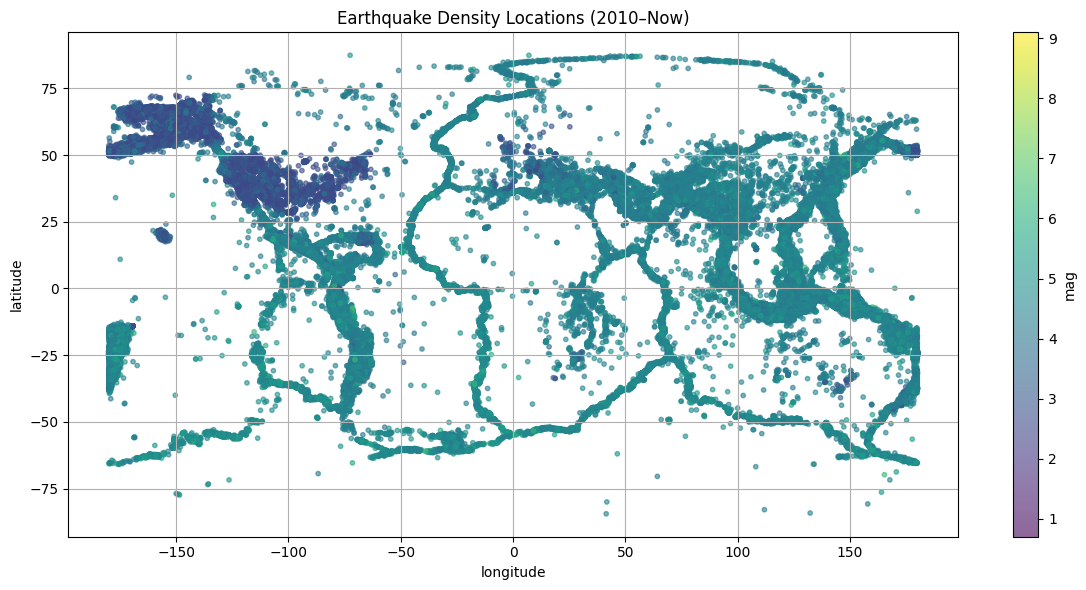

In [26]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))

# Use magnitude for coloring
scatter = plt.scatter(
    merged_df['longitude'],
    merged_df['latitude'],
    c=merged_df['mag'],         # Color by magnitude
    cmap='viridis',                # Choose a color map (e.g. 'plasma', 'inferno', 'coolwarm')
    s=10,                          # Slightly larger dots for visibility
    alpha=0.6                      # Transparency
)

# Add plot elements
plt.title("Earthquake Density Locations (2010–Now)")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.grid(True)

# Add colorbar as legend
cbar = plt.colorbar(scatter)
cbar.set_label("mag")

plt.tight_layout()
plt.show()

**Ploting a line chart to see trend line in total earthquakes per year over the last 15 years old**

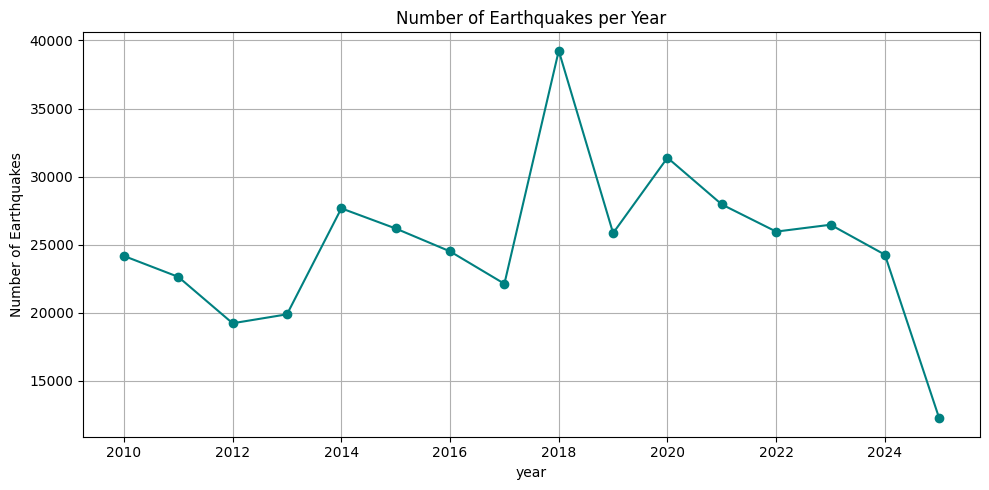

In [27]:
import matplotlib.pyplot as plt

yearly_counts = merged_df['year'].value_counts().sort_index()

#  Plot line chart
plt.figure(figsize=(10, 5))
plt.plot(yearly_counts.index, yearly_counts.values, marker='o', linestyle='-',color='teal')
plt.title("Number of Earthquakes per Year")
plt.xlabel("year")
plt.ylabel("Number of Earthquakes")
plt.grid(True)
plt.tight_layout()
plt.show()

**Ploting a line chart to see trend line in total earthquakes per month over the last 15 years old**

<Axes: xlabel='month'>

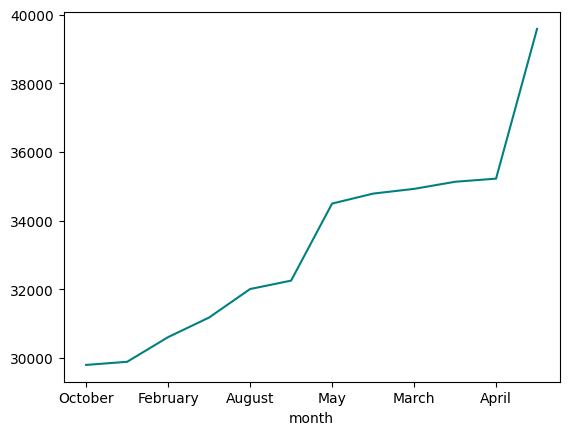

In [28]:
monthly_trend = merged_df.groupby('month').size().sort_values()

monthly_trend.plot(kind='line', color='teal')

**Ploting a line chart to see trend line in Average earthquakes magnitude per year over the last 15 years old**

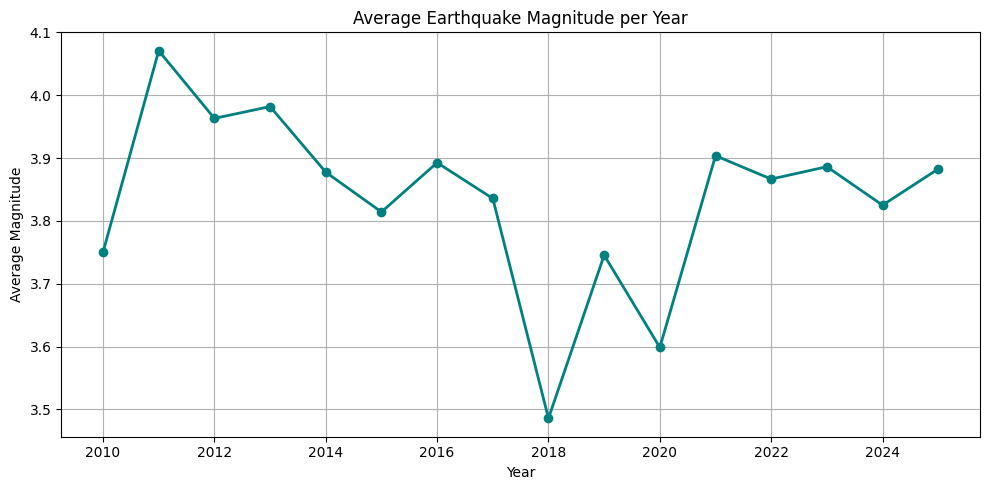

In [29]:
# Group by year and calculate average magnitude
avg_mag_per_year = merged_df.groupby('year')['mag'].mean()

# Plot it
plt.figure(figsize=(10, 5))
plt.plot(avg_mag_per_year.index, avg_mag_per_year.values, marker='o', color='teal', linewidth=2)
plt.title("Average Earthquake Magnitude per Year")
plt.xlabel("Year")
plt.ylabel("Average Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()

**Ploting a line chart to see trend line in Max earthquakes magnitude per year over the last 15 years old**

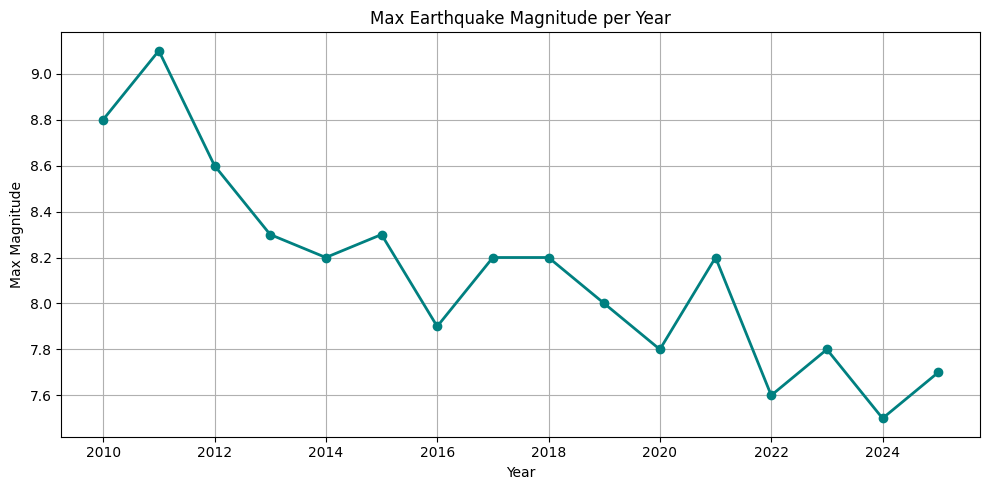

In [30]:
# Group by year and calculate max magnitude
max_mag_per_year = merged_df.groupby('year')['mag'].max()

# Plot it
plt.figure(figsize=(10, 5))
plt.plot(max_mag_per_year.index, max_mag_per_year.values, marker='o', color='teal', linewidth=2)
plt.title("Max Earthquake Magnitude per Year")
plt.xlabel("Year")
plt.ylabel("Max Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()

**Ploting a bar chart to see  Average earthquakes magnitude per month over the last 15 years old**

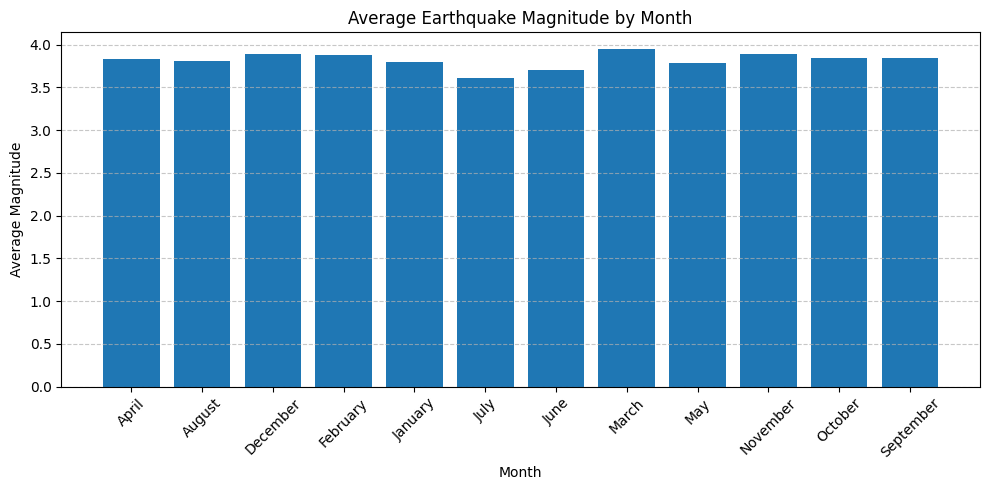

In [31]:
#Group by month and calculate average magnitude
monthly_avg_mag =  merged_df.groupby('month')['mag'].mean().sort_index()

# Plot it!
plt.figure(figsize=(10, 5))
plt.bar(monthly_avg_mag.index, monthly_avg_mag.values)
plt.title('Average Earthquake Magnitude by Month')
plt.xlabel('Month')
plt.ylabel('Average Magnitude')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

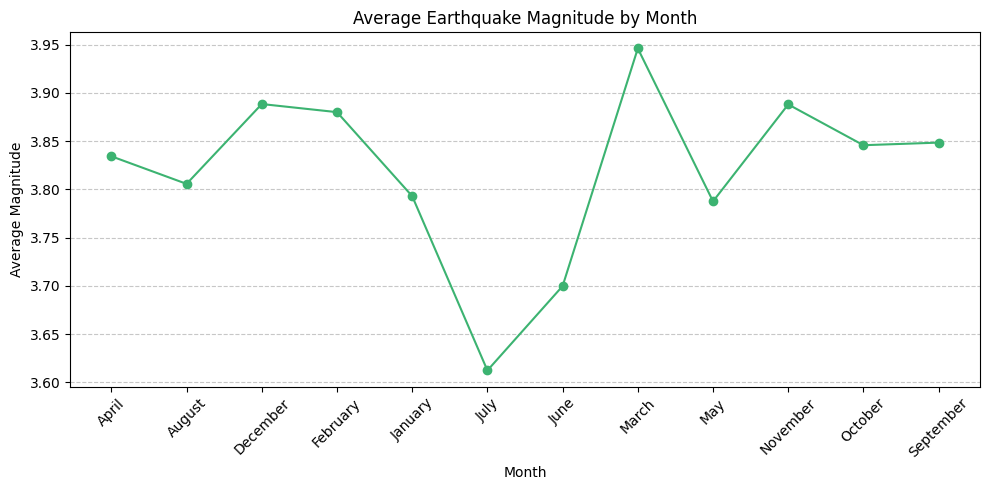

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg_mag.index, monthly_avg_mag.values, marker='o', linestyle='-', color='mediumseagreen')

plt.title('Average Earthquake Magnitude by Month')
plt.xlabel('Month')
plt.ylabel('Average Magnitude')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Ploting a line chart to see trend line in Max earthquakes magnitude per Month over the last 15 years old**

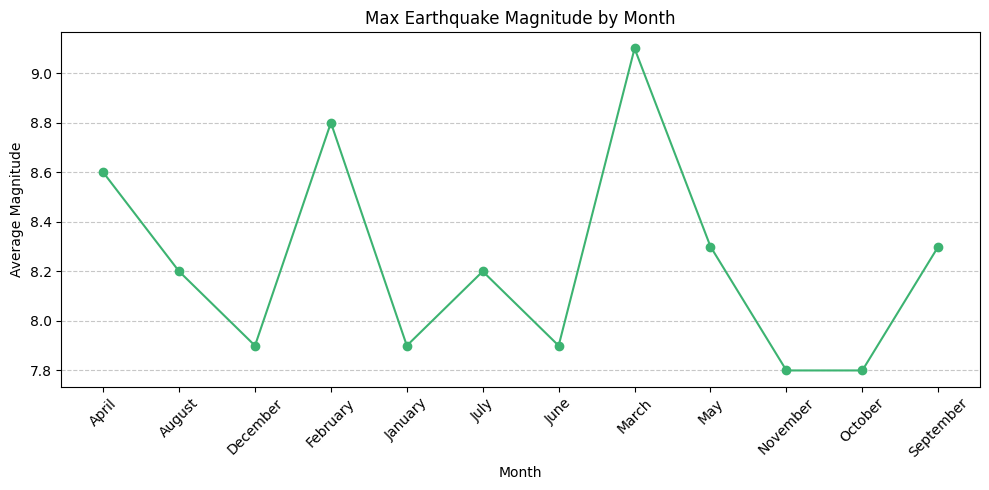

In [33]:
max_mag_per_month = merged_df.groupby('month')['mag'].max().sort_index()
plt.figure(figsize=(10, 5))
plt.plot(max_mag_per_month.index, max_mag_per_month.values, marker='o', linestyle='-', color='mediumseagreen')

plt.title('Max Earthquake Magnitude by Month')
plt.xlabel('Month')
plt.ylabel('Average Magnitude')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [34]:
correlation = merged_df["mag"].corr(merged_df["depth"])
print(f"🔎 Correlation between magnitude and depth: {correlation:.4f}")

🔎 Correlation between magnitude and depth: 0.2008


**Ploting a Scatter plot to see Relationship between Earthquakes magnitude & country longitude**

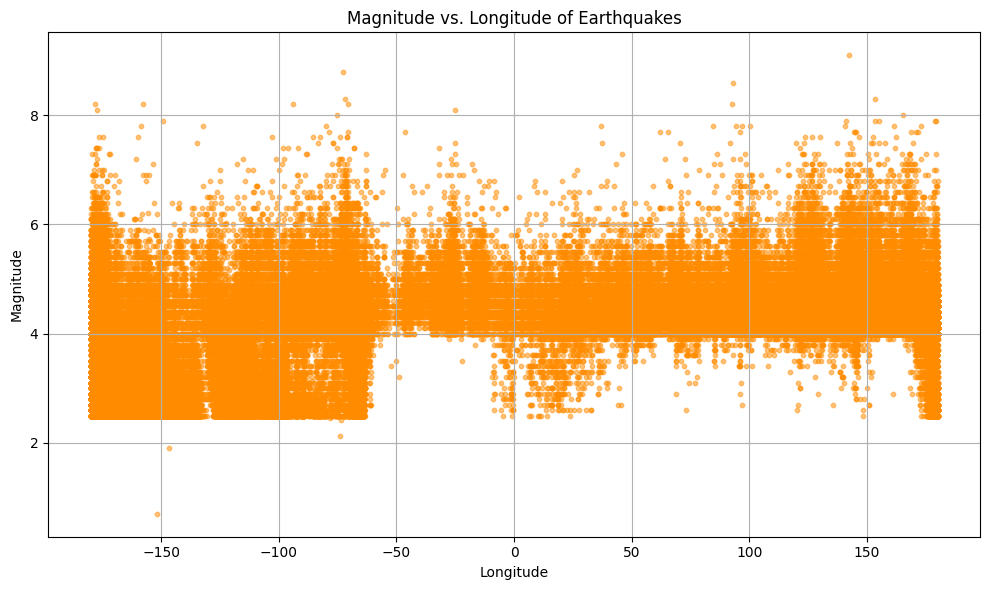

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(merged_df["longitude"], merged_df["mag"], alpha=0.5, s=10, color="darkorange")

plt.title("Magnitude vs. Longitude of Earthquakes")
plt.xlabel("Longitude")
plt.ylabel("Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()

**Ploting a Scatter plot to see Relationship between Earthquakes magnitude & Depth**

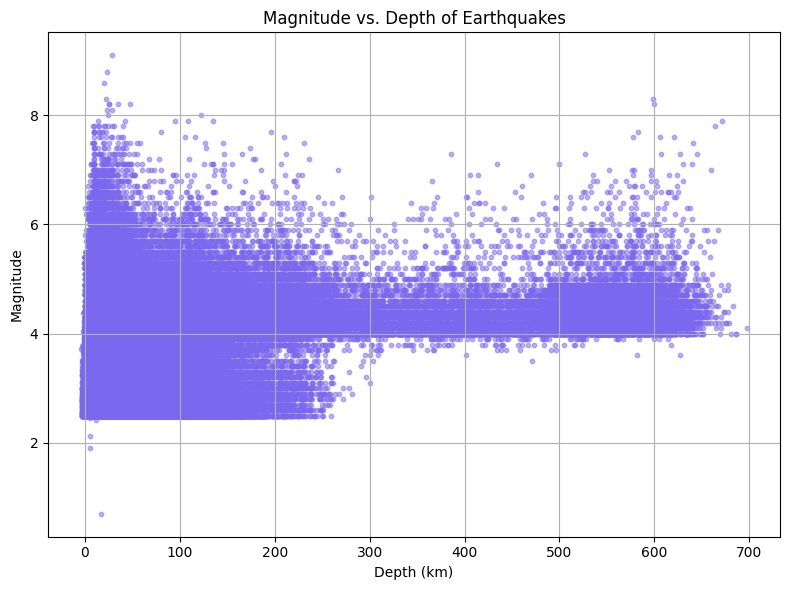

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(merged_df["depth"], merged_df["mag"], alpha=0.5, s=10, color="mediumslateblue")
plt.title("Magnitude vs. Depth of Earthquakes")
plt.xlabel("Depth (km)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()

**ploting top 5 countries with most frequent earthquakes**

In [37]:
# calculating top 5 countries which have most earthquakes for the last 15 years
top_5_countries = (
    merged_df['standardized_country']
    .value_counts()
    .head(10)
)

# Display results
print(top_5_countries)

standardized_country
United States of America    143886
Indonesia                    24885
Puerto Rico                  22900
Japan                        21641
Chile                        11642
Papua New Guinea             11258
Mexico                       11001
Philippines                   9771
New Zealand                   9140
Tonga                         7768
Name: count, dtype: int64


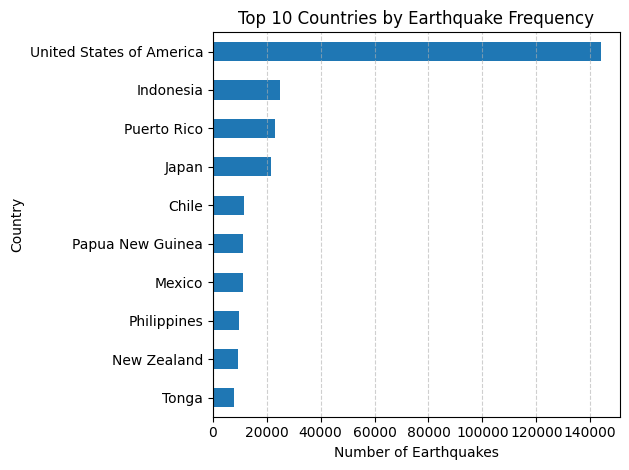

In [38]:
# ploting top 5 countries with most frequent earthquakes
top_5_countries.plot(kind='barh')
plt.xlabel("Number of Earthquakes")
plt.ylabel("Country")
plt.title("Top 10 Countries by Earthquake Frequency")
plt.gca().invert_yaxis()  # So the highest is at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [39]:
# Grouping country and compute average magnitude for top 5 country  
avg_mag_by_country = (
    merged_df.groupby('standardized_country')['mag']
    .mean()
    .sort_values(ascending=False)
    .head(5)
)

# Display the top 5
print(avg_mag_by_country)

standardized_country
Western Caribbean Sea              5.4
South of the Mariana Islands       5.3
Ross Sea                           5.1
Panama-Costa Rica border region    5.1
South Georgia Rise                 5.1
Name: mag, dtype: float64


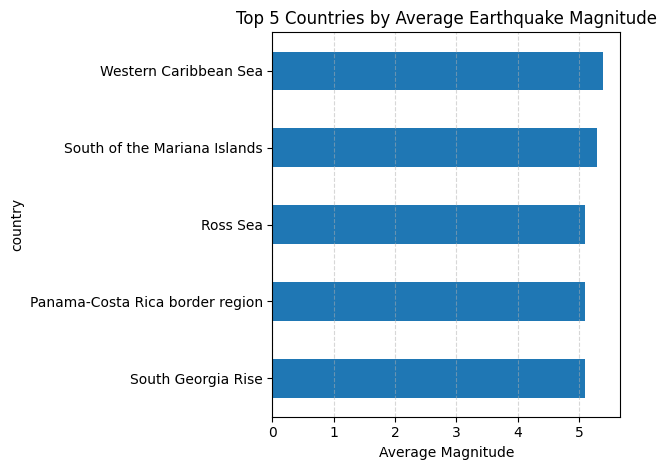

In [40]:
# plotting top 5 countries with average magnitude
avg_mag_by_country.plot(kind='barh')
plt.xlabel("Average Magnitude")
plt.ylabel("country")
plt.gca().invert_yaxis()  # So the highest is at the top
plt.title("Top 5 Countries by Average Earthquake Magnitude")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

**Plotting Total Earthquake Deaths per Year**

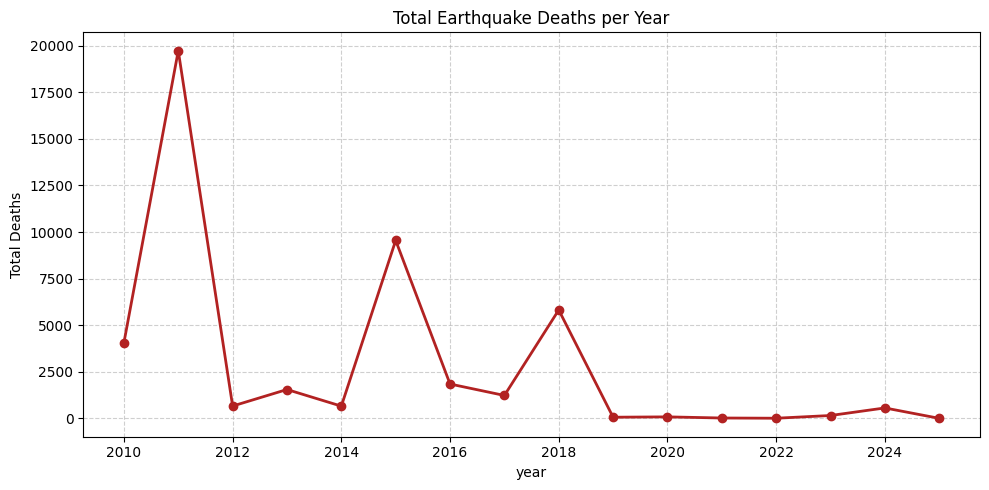

In [41]:
import matplotlib.pyplot as plt

# Group and sum deaths by year
deaths_per_year = merged_df.groupby('year')['Total Deaths'].sum()

# Plot the line chart
plt.figure(figsize=(10, 5))
plt.plot(deaths_per_year.index, deaths_per_year.values, marker='o', color='firebrick', linewidth=2)

plt.title("Total Earthquake Deaths per Year")
plt.xlabel("year")
plt.ylabel("Total Deaths")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**Plotting Correlation Heatmap of Earthquake Dataset Features**

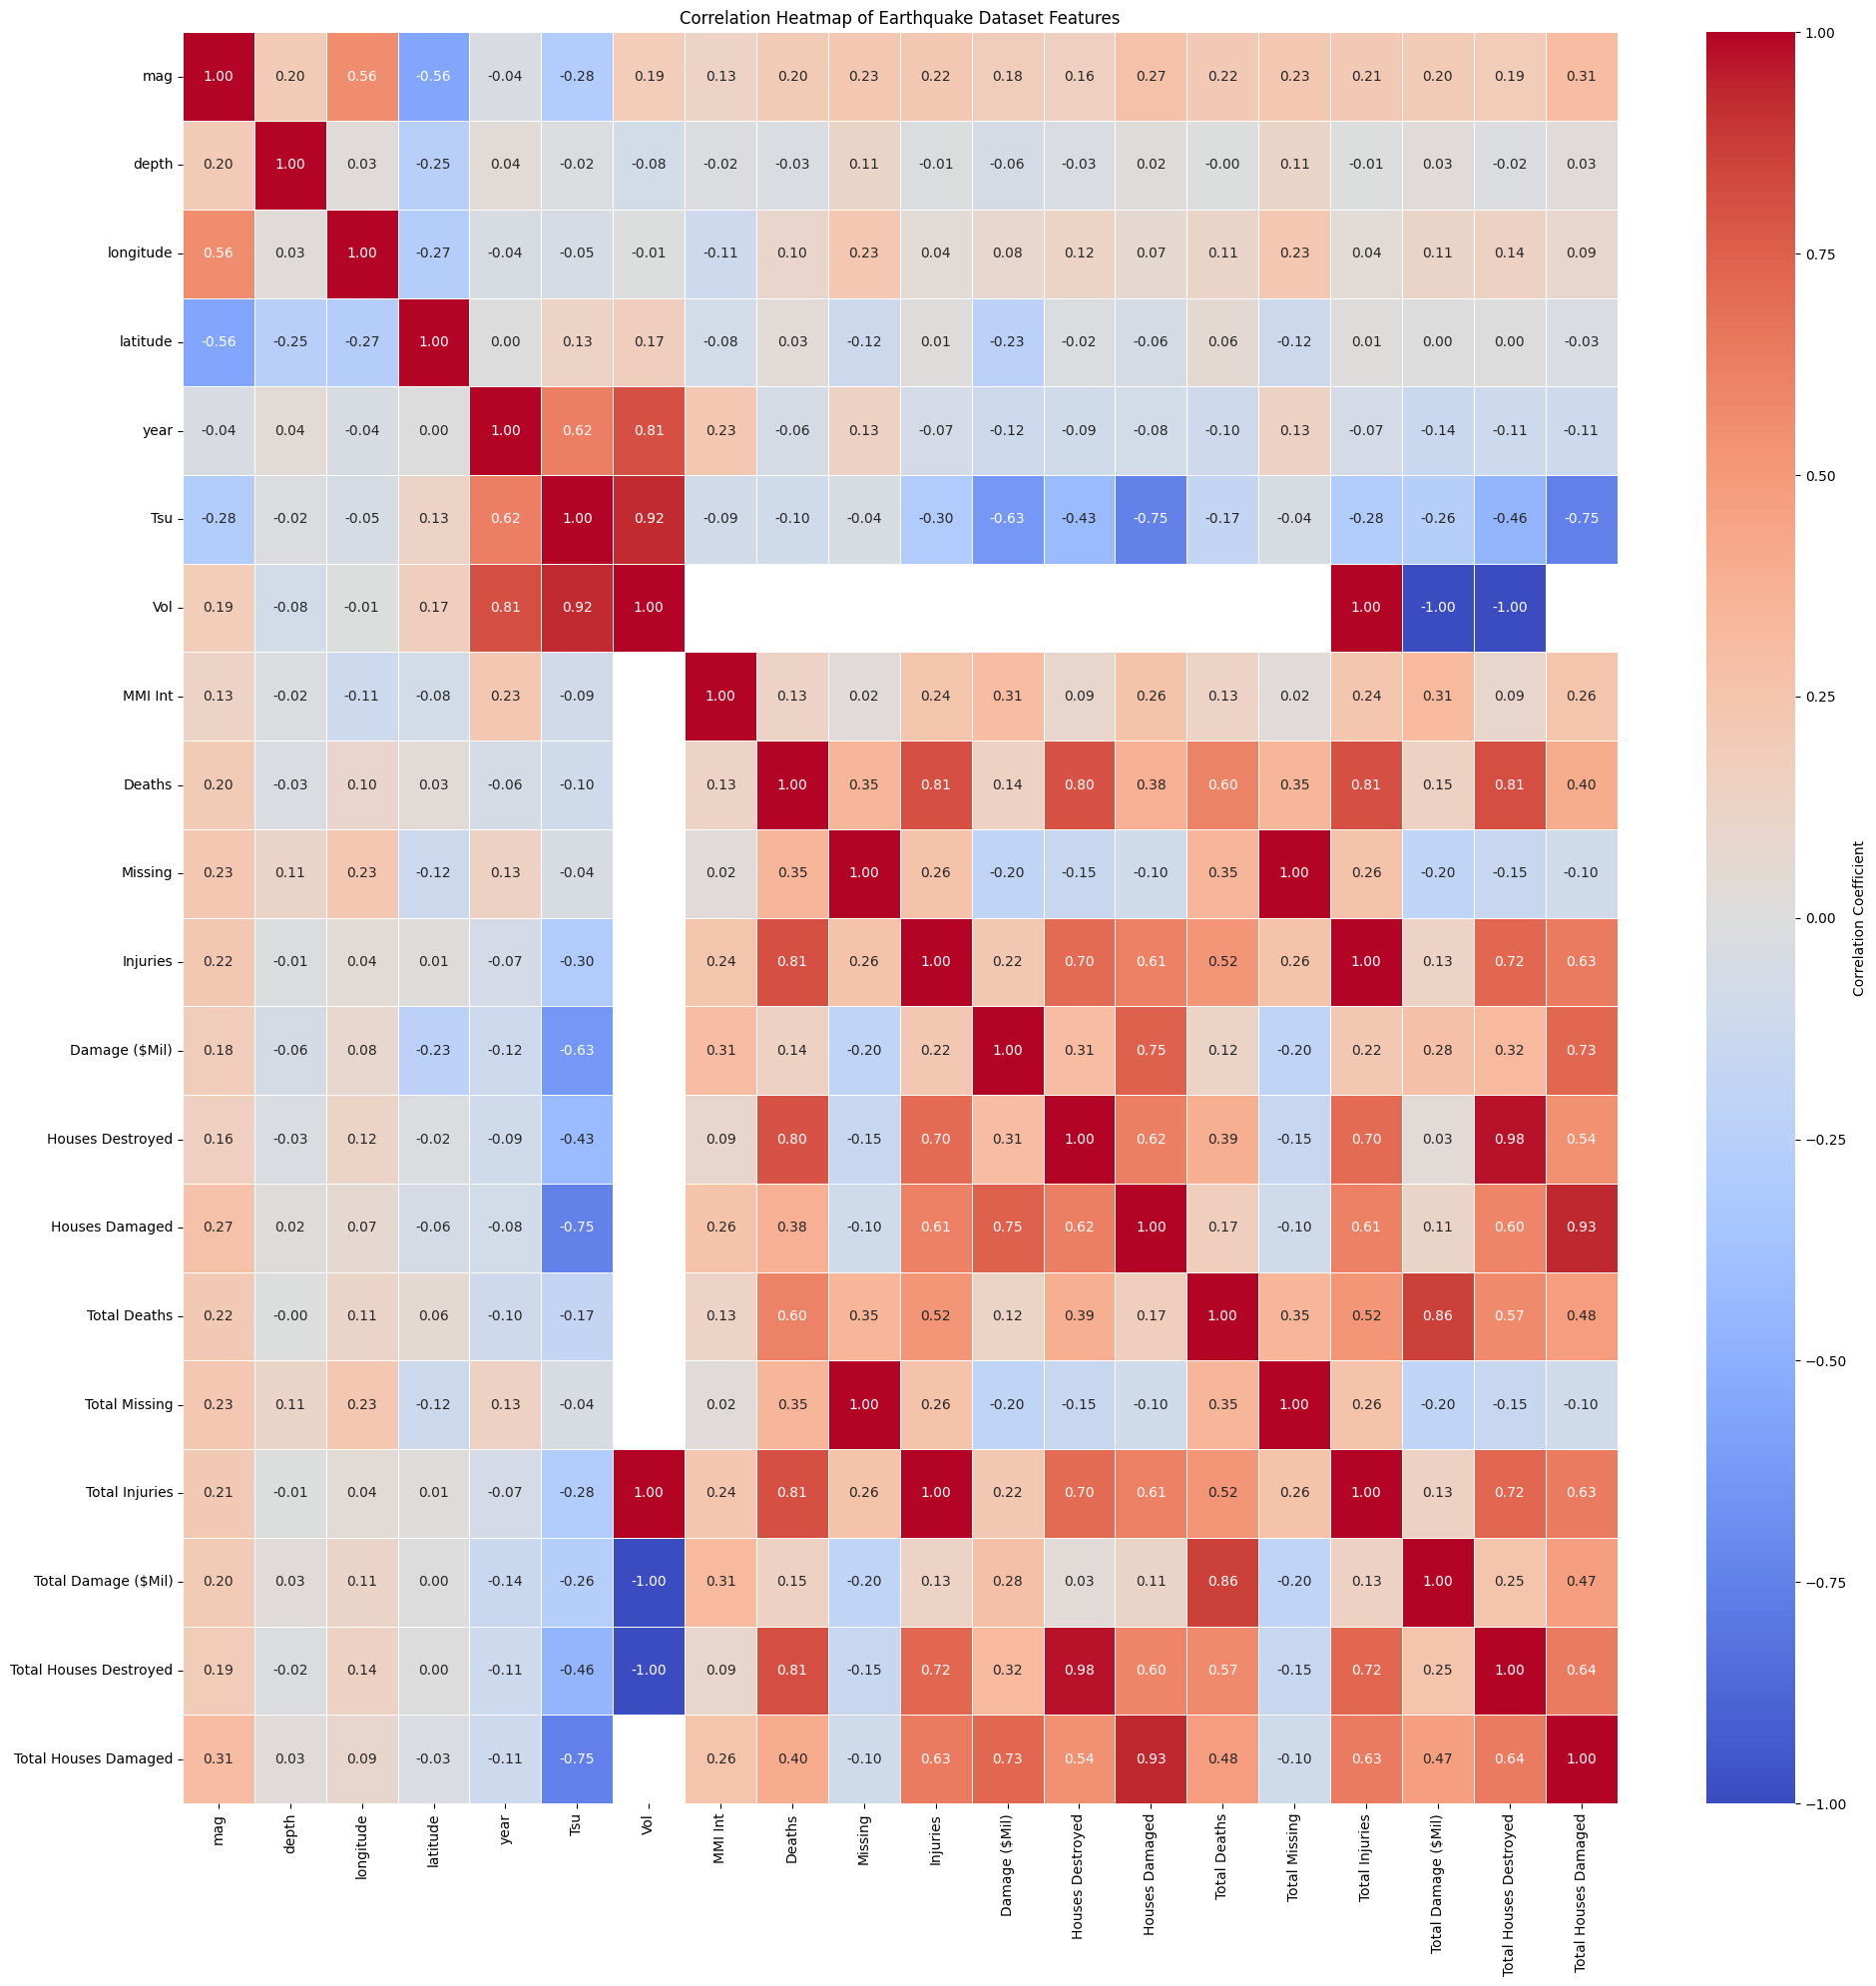

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_focus = merged_df[["mag","depth","longitude","latitude","year",
                           "Tsu","Vol","MMI Int","Deaths","Missing", "Injuries",
                          "Damage ($Mil)","Houses Destroyed","Houses Damaged","Total Deaths", "Total Missing",
                          "Total Injuries","Total Damage ($Mil)","Total Houses Destroyed","Total Houses Damaged"]]
numeric_merged_df= df_focus.select_dtypes(include='number')

correlation_matrix = numeric_merged_df.corr()


# Plot heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(
    correlation_matrix,
    annot=True,             # Show correlation values
    fmt=".2f",              # Format values to 2 decimals
    cmap="coolwarm",        # Color scale from negative to positive
    linewidths=0.5,         # Line thickness between cells
    cbar_kws={"label": "Correlation Coefficient"}
)

plt.title("Correlation Heatmap of Earthquake Dataset Features")
plt.tight_layout()
plt.show()


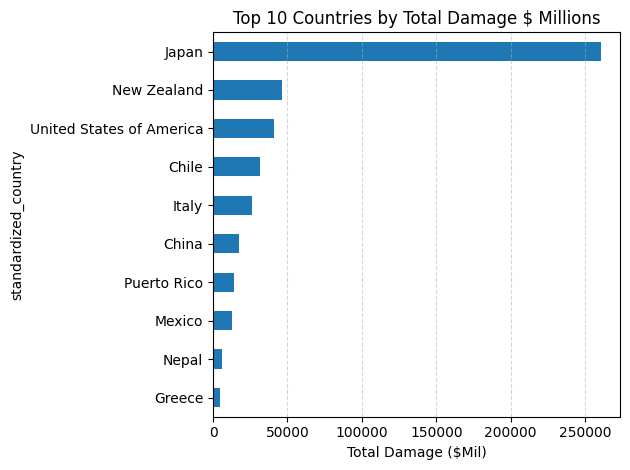

In [45]:
top10_damage_per_country= merged_df.groupby('standardized_country')['Total Damage ($Mil)'].sum().sort_values(ascending=False).head(10)
top10_damage_per_country.plot(kind='barh')
plt.xlabel("Total Damage ($Mil)")
plt.ylabel("standardized_country")
plt.gca().invert_yaxis()  # So the highest is at the top
plt.title("Top 10 Countries by Total Damage $ Millions")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

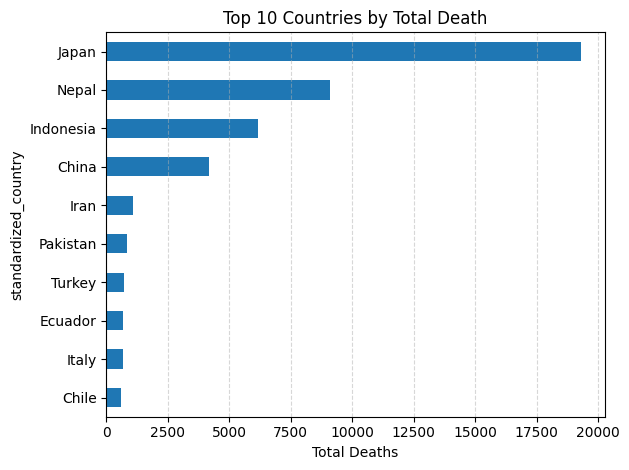

In [46]:
top10_deaths_per_country = merged_df.groupby('standardized_country')['Total Deaths'].sum().sort_values(ascending=False).head(10)
top10_deaths_per_country.plot(kind='barh')
plt.xlabel("Total Deaths")
plt.ylabel("standardized_country")
plt.gca().invert_yaxis()  # So the highest is at the top
plt.title("Top 10 Countries by Total Death")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

**Plotting Total Earthquake Damages per Year**

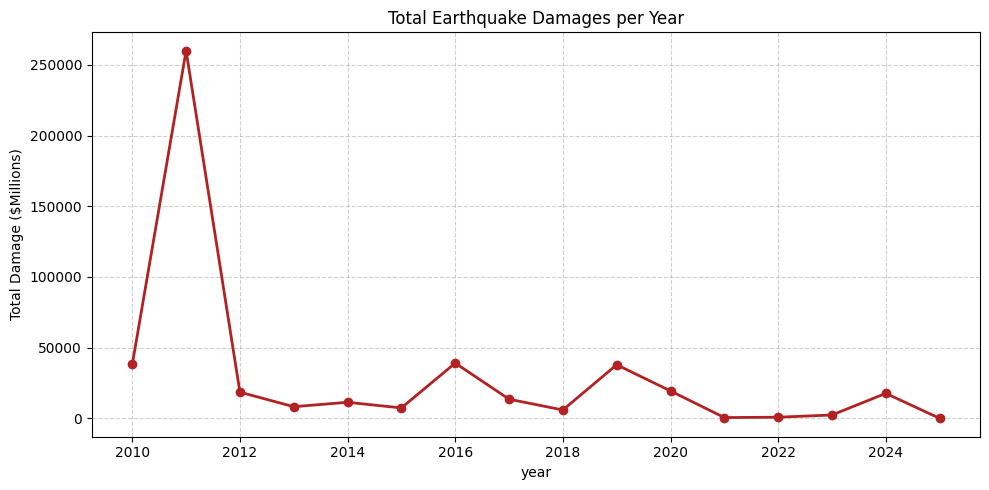

In [47]:
# Group and sum damages by year
damage_per_year = merged_df.groupby('year')['Total Damage ($Mil)'].sum()

# Plot the line chart
plt.figure(figsize=(10, 5))
plt.plot(damage_per_year.index, damage_per_year.values, marker='o', color='firebrick', linewidth=2)

plt.title("Total Earthquake Damages per Year")
plt.xlabel("year")
plt.ylabel("Total Damage ($Millions)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

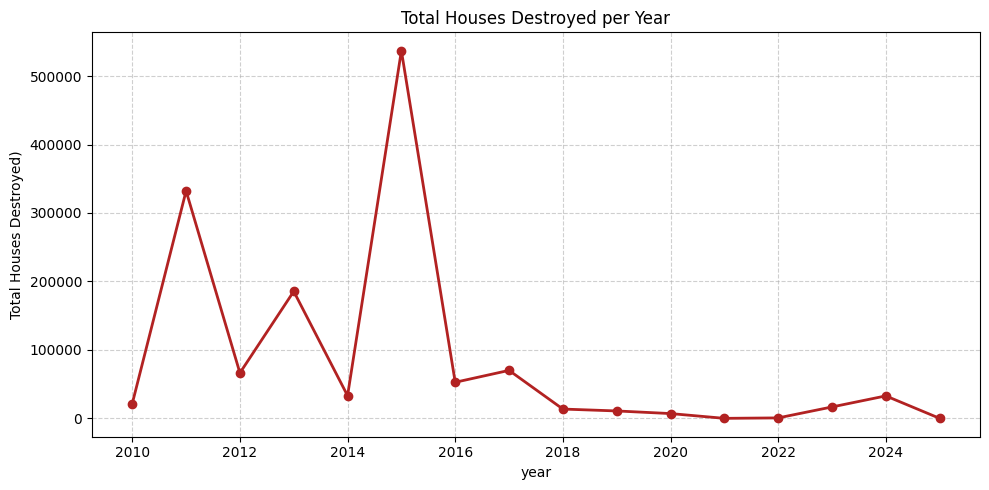

In [48]:
house_destroyed_per_year= merged_df.groupby('year')['Total Houses Destroyed'].sum()
# Plot the line chart
plt.figure(figsize=(10, 5))
plt.plot(house_destroyed_per_year.index, house_destroyed_per_year.values, marker='o', color='firebrick', linewidth=2)

plt.title("Total Houses Destroyed per Year")
plt.xlabel("year")
plt.ylabel("Total Houses Destroyed)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

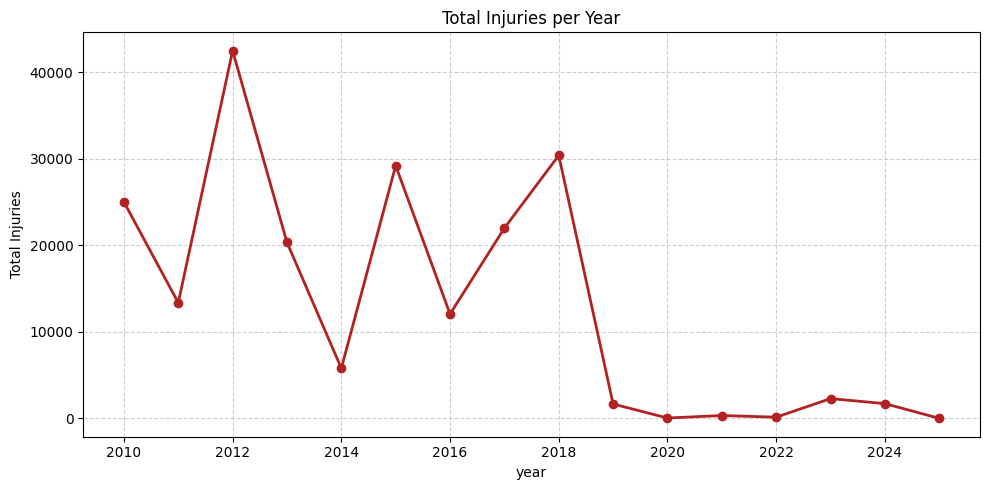

In [49]:
injuries_per_year= merged_df.groupby('year')['Total Injuries'].sum()
# Plot the line chart
plt.figure(figsize=(10, 5))
plt.plot(injuries_per_year.index, injuries_per_year.values, marker='o', color='firebrick', linewidth=2)

plt.title("Total Injuries per Year")
plt.xlabel("year")
plt.ylabel("Total Injuries")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

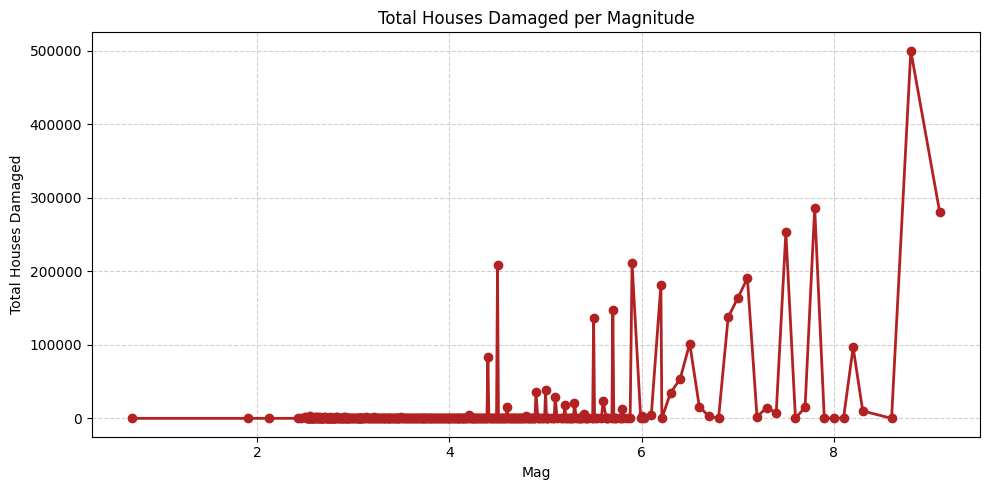

In [50]:
house_damaged_per_mag= merged_df.groupby('mag')['Total Houses Damaged'].sum()
# Plot the line chart
plt.figure(figsize=(10, 5))
plt.plot(house_damaged_per_mag.index, house_damaged_per_mag.values, marker='o', color='firebrick', linewidth=2)

plt.title("Total Houses Damaged per Magnitude")
plt.xlabel("Mag")
plt.ylabel("Total Houses Damaged")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

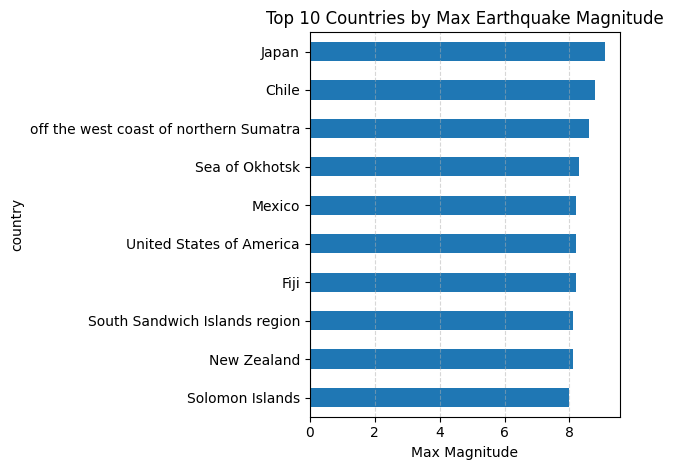

In [51]:
# Grouping country and compute max magnitude for top 10 country  
max_mag_by_country = (
    merged_df.groupby('standardized_country')['mag']
    .max()
    .sort_values(ascending=False).head(10)
    
)

# plotting top 10 countries with Max magnitude
max_mag_by_country.plot(kind='barh')
plt.xlabel("Max Magnitude")
plt.ylabel("country")
plt.gca().invert_yaxis()  # So the highest is at the top
plt.title("Top 10 Countries by Max Earthquake Magnitude")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

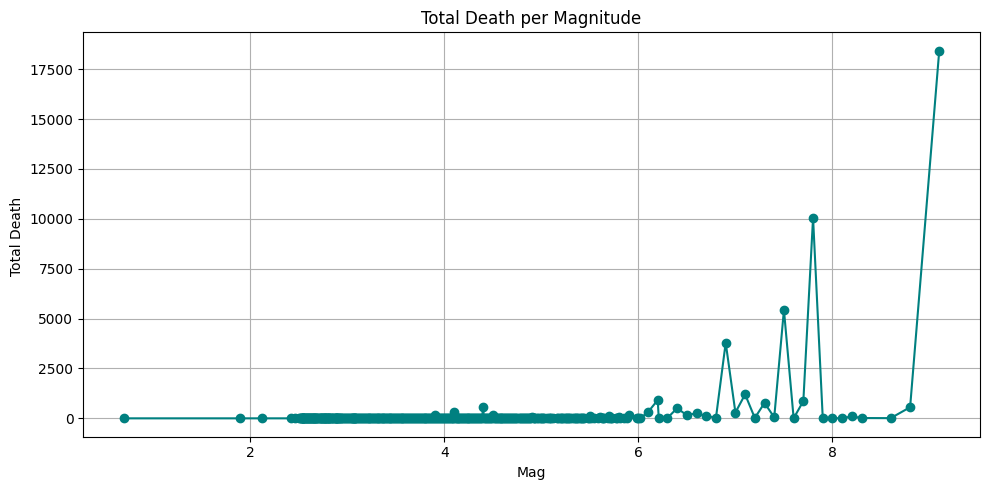

In [52]:
import matplotlib.pyplot as plt

total_death_by_mag = merged_df.groupby('mag')['Total Deaths'].sum().sort_index()

#  Plot line chart
plt.figure(figsize=(10, 5))
plt.plot(total_death_by_mag.index, total_death_by_mag.values, marker='o', linestyle='-',color='teal')
plt.title("Total Death per Magnitude")
plt.xlabel("Mag")
plt.ylabel("Total Death ")
plt.grid(True)
plt.tight_layout()
plt.show()

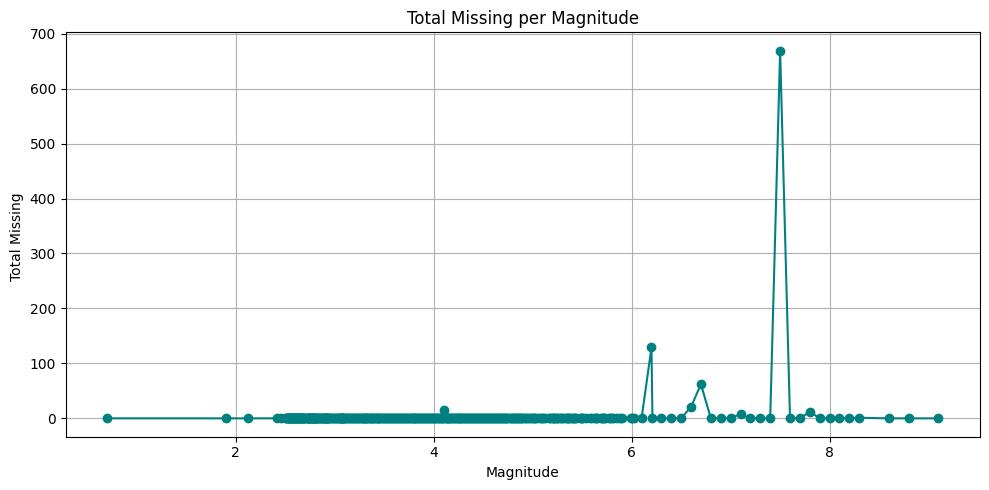

In [53]:
import matplotlib.pyplot as plt

total_missing_by_mag = merged_df.groupby('mag')['Total Missing'].sum().sort_index()

#  Plot line chart
plt.figure(figsize=(10, 5))
plt.plot(total_missing_by_mag.index, total_missing_by_mag.values, marker='o', linestyle='-',color='teal')
plt.title("Total Missing per Magnitude")
plt.xlabel("Magnitude")
plt.ylabel("Total Missing ")
plt.grid(True)
plt.tight_layout()
plt.show()


**Insights from this analysis**


*highest earthquake magnitude, the maximum number of deaths, and the year it occurred*


In [54]:
# Find the row with the highest magnitude
max_mag_row = merged_df.loc[merged_df['mag'].idxmax()]

# Find the row with the highest death count
max_death_row = merged_df.loc[merged_df['Total Deaths'].idxmax()]

In [55]:
print("🔷 Largest Magnitude:")
print(f"Country: {max_mag_row['standardized_country']}, Magnitude: {max_mag_row['mag']}, Year: {max_mag_row['year']}")

print("\n🔶 Maximum Deaths:")
print(f"Country: {max_death_row['standardized_country']}, Deaths: {max_death_row['Total Deaths']}, Year: {max_death_row['year']}")

🔷 Largest Magnitude:
Country: Japan, Magnitude: 9.1, Year: 2011

🔶 Maximum Deaths:
Country: Japan, Deaths: 18428.0, Year: 2011


*The year with the most earthquake*

In [56]:
earthquake_counts = merged_df.groupby('year').size().sort_values(ascending=False)

# Get the year with the highest count
top_year = earthquake_counts.idxmax()
top_count = earthquake_counts.max()

print(f"📅 Year with the most earthquakes: {top_year} ({top_count} events)")

📅 Year with the most earthquakes: 2018 (39244 events)


In [57]:
import pandas as pd



# Ensure 'Total Deaths' is numeric, coercing errors to NaN
merged_df['Total Deaths'] = pd.to_numeric(merged_df['Total Deaths'], errors='coerce')

# Find the row with the maximum 'Total Deaths'
# .idxmax() returns the index of the first occurrence of the maximum value
max_death_row = merged_df.loc[merged_df['Total Deaths'].idxmax()]

# Extract the value for 'Total Deaths'
total_deaths_value = max_death_row['Total Deaths']

# Extract the year for context
year_of_max_deaths = max_death_row['year']

# Print the result
print(f"The maximum recorded total deaths is: {total_deaths_value} in the year {year_of_max_deaths}")

# If you specifically want to find the Haiti earthquake by filtering:
# You would need more specific columns for filtering, like 'place' or precise lat/lon
# For example:
# haiti_earthquake = merged_df[(merged_df['year'] == 2010) & (merged_df['place'].str.contains('Haiti', na=False))]
# if not haiti_earthquake.empty:
#     haiti_deaths = haiti_earthquake['Total Deaths'].iloc[0]
#     print(f"Haiti 2010 earthquake deaths: {haiti_deaths}")

The maximum recorded total deaths is: 18428.0 in the year 2011


**Egypt Earthquake insights**

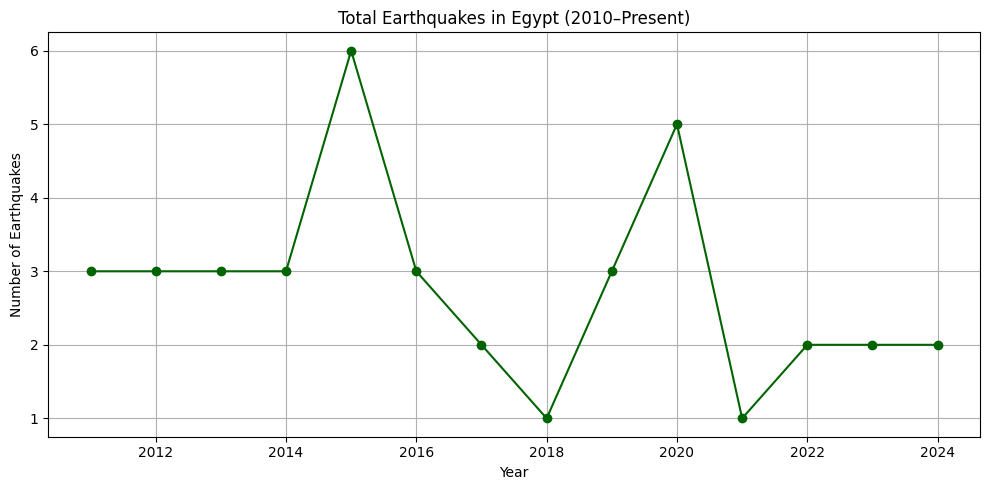

In [58]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter earthquakes in Egypt from 2010 onward
egypt_quakes = merged_df[(merged_df['standardized_country'] == 'Egypt') & (merged_df['year'] >= 2010)]

# Count earthquakes per year
egypt_counts = egypt_quakes['year'].value_counts().sort_index()

# Plot the line chart
plt.figure(figsize=(10, 5))
plt.plot(egypt_counts.index, egypt_counts.values, marker='o', linestyle='-', color='darkgreen')
plt.title("Total Earthquakes in Egypt (2010–Present)")
plt.xlabel("Year")
plt.ylabel("Number of Earthquakes")
plt.grid(True)
plt.tight_layout()
plt.show()

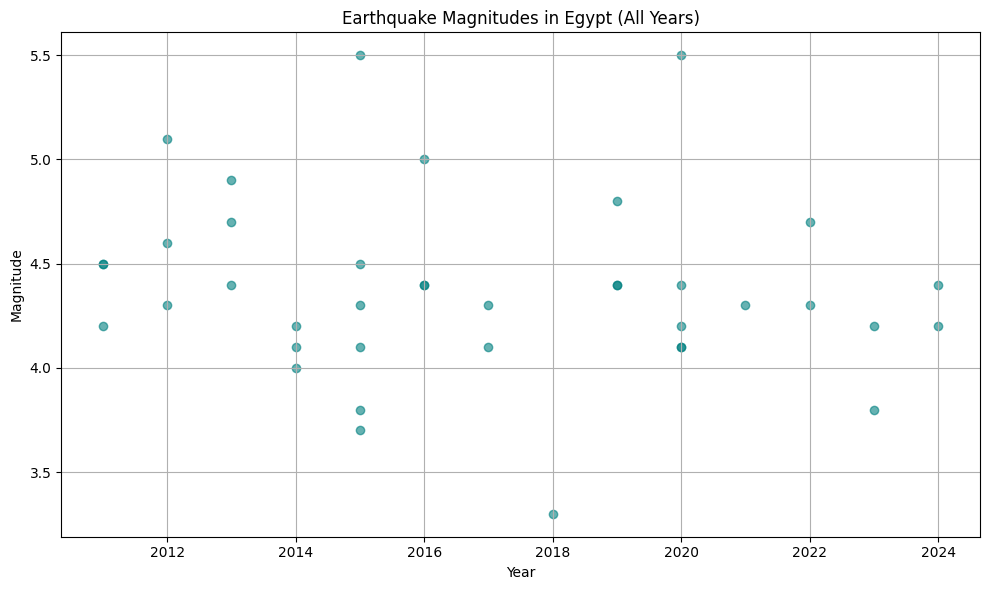

In [59]:
import matplotlib.pyplot as plt

# Filter data for earthquakes in Egypt
egypt_quakes = merged_df[merged_df['standardized_country'] == 'Egypt']

# Drop rows with missing magnitude or year (just to be safe)
egypt_quakes = egypt_quakes.dropna(subset=['mag', 'year'])

# Plot magnitudes by year
plt.figure(figsize=(10, 6))
plt.scatter(egypt_quakes['year'], egypt_quakes['mag'], color='teal', alpha=0.6)
plt.title('Earthquake Magnitudes in Egypt (All Years)')
plt.xlabel('Year')
plt.ylabel('Magnitude')
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
#Egypt total Earthquakes
egypt_total_earthquake = egypt_counts.sum()
print("Egypt total Earthquakes = " ,egypt_total_earthquake )

Egypt total Earthquakes =  39
